In [1]:
from typing import TypedDict, Annotated
import operator

from langgraph.graph import StateGraph, END

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Next-80B-A3B-Instruct",
    max_new_tokens=1024,
    temperature=0,
)

chat_model = ChatHuggingFace(llm=llm)

In [4]:
tool = TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_27119/356220288.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [18]:
class Agent:

    def __init__(self, model, tools, system=""):

        self.system = system
        graph = StateGraph(AgentState)

        graph.add_node("llm", self.call_model)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {
                True: "action", False: END
            }
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")

        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_model(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []

        for t in tool_calls:
            print(f"Calling: '{t}' ")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(
                tool_call_id=t["id"], 
                name=t["name"], 
                content=str(result)
            ))
        
        return {"messages": results}

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

In [19]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(chat_model, [tool], system=prompt)

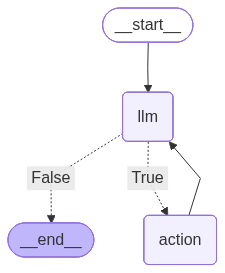

In [20]:
from IPython.display import Image, display

display(Image(abot.graph.get_graph().draw_mermaid_png()))

In [21]:
messages = [HumanMessage(content="What is the weather in Darmstadt, Germany?")]
result = abot.graph.invoke({"messages": messages}) # state

Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Darmstadt, Germany'}, 'id': 'call_f5c0ad5e5fc548f99d21af', 'type': 'tool_call'}' 


In [22]:
result

{'messages': [HumanMessage(content='What is the weather in Darmstadt, Germany?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Darmstadt, Germany"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_f5c0ad5e5fc548f99d21af', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 261, 'total_tokens': 291}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--501fbba6-1135-47b7-a3bc-212e0b367cec-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Darmstadt, Germany'}, 'id': 'call_f5c0ad5e5fc548f99d21af', 'type': 'tool_call'}], usage_metadata={'input_tokens': 261, 'output_tokens': 30, 'total_tokens': 291}),
  ToolMessage(content='[{\'title\': \'Darmstadt , Hesse, Germany Weather Forecast |

In [24]:
from pprint import pprint

pprint(result["messages"][-1].content)

('The current weather in Darmstadt, Germany, as of the latest information, is '
 'overcast with a high of 62°F (approximately 17°C) and a low of 53°F '
 '(approximately 12°C). There is a chance of showers late in the night, and '
 'the weather is expected to remain cloudy with occasional rain through the '
 'upcoming days. Windy conditions are also anticipated, especially in the '
 'afternoon and evening.\n'
 '\n'
 'For real-time updates, you can check live weather services like AccuWeather '
 'or Weather25.')


In [25]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

abot = Agent(chat_model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'who won the Super Bowl in 2024'}, 'id': 'call_4b31fabfcc6246a2b91292', 'type': 'tool_call'}' 
Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'where is the headquarters of the Kansas City Chiefs located'}, 'id': 'call_0cd8052ffaab4177ac5d46', 'type': 'tool_call'}' 
Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri state 2024'}, 'id': 'call_c7c9d3bd7734420d9b4e9b', 'type': 'tool_call'}' 


In [26]:
pprint(result["messages"][-1].content)

('The Kansas City Chiefs won the Super Bowl in 2024, defeating the San '
 'Francisco 49ers 25-22 in overtime. \n'
 '\n'
 'The headquarters of the Kansas City Chiefs is located in Missouri, '
 'specifically at 1 Arrowhead Drive, Kansas City, Missouri.\n'
 '\n'
 'As of 2024, the gross domestic product (GDP) of Missouri was $356.7 billion, '
 'representing a 2.3% increase from 2023.')
